In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the cleaned dataset
df_org = pd.read_csv('cleaned.csv', parse_dates=['Time', 'DateTime'])

In [3]:
df = df_org[df_org['CH Load'] != 0].reset_index(drop=True)

In [4]:

# Extract time-based features
df['Hour'] = df['Time'].dt.hour
df['DayOfWeek'] = df['Time'].dt.dayofweek  # Monday=0, Sunday=6
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [5]:
features = [
    'RT', 'kW_Tot', 'kW_RT', 'kW_CHH', 'kW_CHP', 'kW_CHS',
    'kW_CDS', 'kW_CT', 'GPM', 'DeltaCHW', 'CHWS', 'CHWR',
    'DeltaCDW', 'CDHI', 'CDLO', 'DeltaCT', 'Hz_ CHP', 'Hz_CHS',
    'Hz_CDS', 'Hz_CT', 'Precent_CH', 'Precent_ CHP',
    'Precent_CDS', 'Precent_CT', 'RH [%]', 'Temperature [°C]',
    'WBT_C', 'Hour', 'DayOfWeek', 'IsWeekend'
]

In [6]:
# Define the target variable
target = 'CH Load'

In [7]:
# Select features and target
X = df[features]
y = df[target]

In [8]:
# Split data into training and testing sets (chronologically)
n_samples = len(df)
train_size = int(0.8 * n_samples)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

In [9]:
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler on the training data
scaler.fit(X_train)

MinMaxScaler()

In [10]:
# Transform both training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Define the sequence length
seq_length = 24  # Number of time steps (e.g., hourly data over a day)

# Function to create sequences
def create_sequences(X, y, seq_length):
    Xs = []
    ys = []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

In [12]:
# Create sequences for training data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, seq_length)

# Create sequences for testing data
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, seq_length)


In [13]:
# Define the Positional Encoding class
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config().copy()
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)
        # Apply sin to even indices and cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]


In [14]:

# Define the Transformer Encoder layer
def transformer_encoder_layer(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-Head Attention
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Network
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


In [15]:
# Build the Transformer model
def build_model(seq_length, num_features, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0):
    inputs = tf.keras.Input(shape=(seq_length, num_features))
    x = inputs
    # Add Positional Encoding
    x = PositionalEncoding(seq_length, num_features)(x)

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_layer(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    return model


In [16]:
# Instantiate the model
model = build_model(
    seq_length=seq_length,
    num_features=X_train_seq.shape[2],
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=4,
    mlp_units=[64],
    dropout=0.1
)

In [17]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Display model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 30)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 24, 30)    │          0 │ input_layer[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 30)    │     31,518 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 30)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 30)    │         60 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 30)    │          0 │ layer_normalizat… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 128)   │      3,968 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 128)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 30)    │      3,870 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 30)    │         60 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 30)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 30)    │     31,518 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 30)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 30)    │         60 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 30)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 128)   │      3,968 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 24, 30)    │      3,870 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 30)    │         60 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 159,953 (624.82 KB)

 Trainable params: 159,953 (624.82 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=50,
    batch_size=16
)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 1973.7684 - root_mean_squared_error: 44.0943 - val_loss: 191.1008 - val_root_mean_squared_error: 13.8239
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 471.5815 - root_mean_squared_error: 21.6561 - val_loss: 690.9488 - val_root_mean_squared_error: 26.2859
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 261.0556 - root_mean_squared_error: 16.1557 - val_loss: 416.3521 - val_root_mean_squared_error: 20.4047
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 159.5001 - root_mean_squared_error: 12.5924 - val_loss: 42.6262 - val_root_mean_squared_error: 6.5289
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 70.5058 - root_mean_squared_error: 8.3947 - val_loss: 73.0005 - val_root_mean_squared_error: 8.5440
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 64.1152 - root_mean_squared_error: 8.0001 - val_loss: 78.1734 - val_root_mean_squared_error: 8.8416
Epoch 7/50
192/192 

In [19]:
# Predict on the test set
y_pred = model.predict(X_test_seq)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [20]:

# Evaluate the model
mae = mean_absolute_error(y_test_seq, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
r2 = r2_score(y_test_seq, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R^2 Score: {r2:.2f}")

Test MAE: 5.50
Test RMSE: 7.37
Test R^2 Score: 0.70


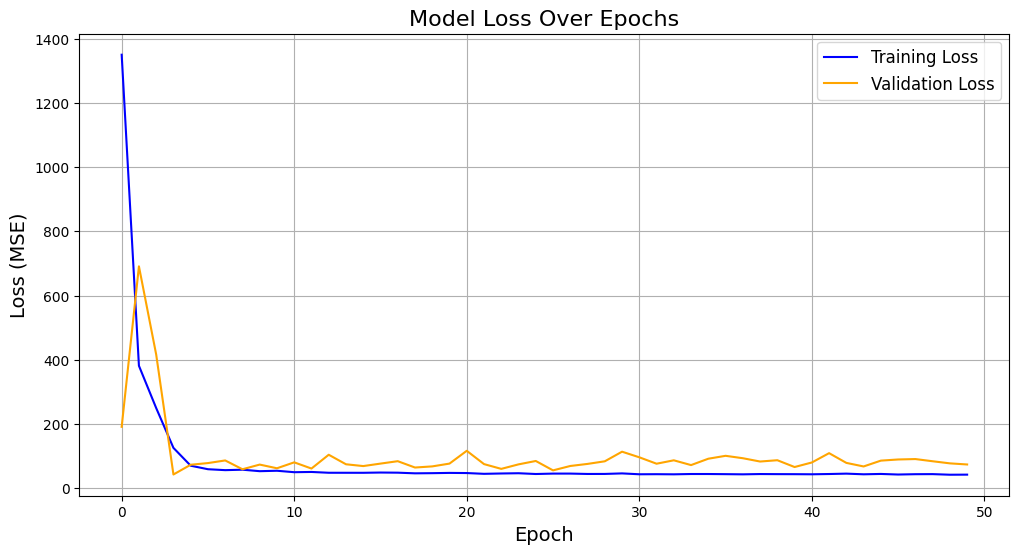

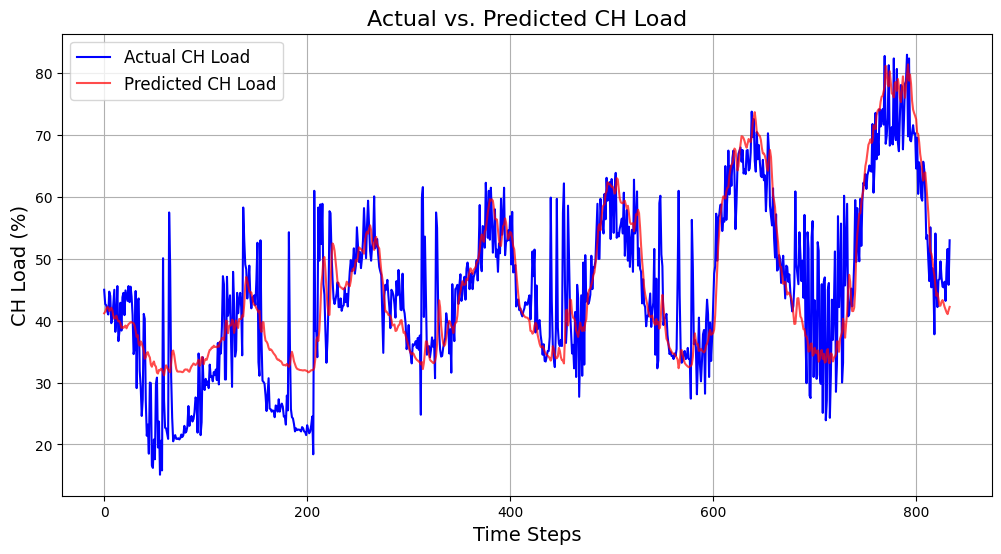

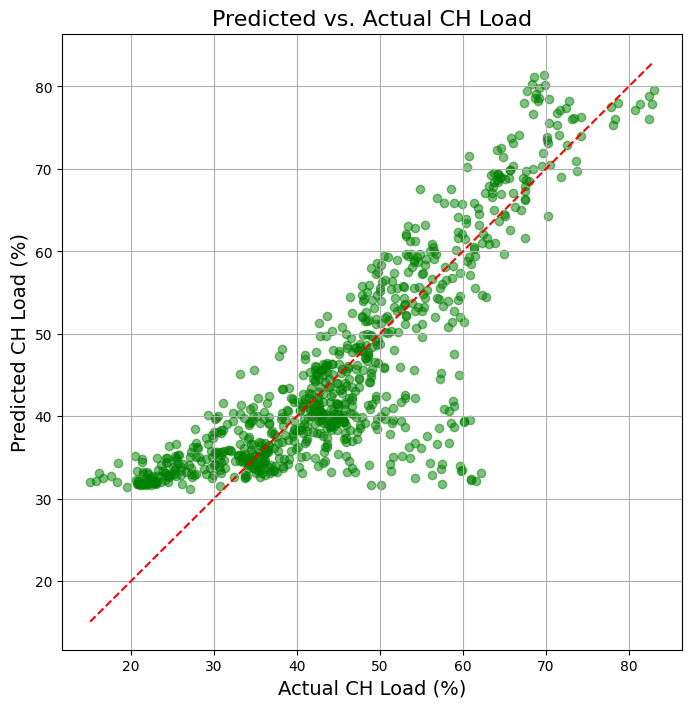

In [21]:
import matplotlib.pyplot as plt

# 1. Plot Training & Validation Loss Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 2. Plot Actual vs. Predicted CH Load on the Test Set
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual CH Load', color='blue')
plt.plot(y_pred, label='Predicted CH Load', color='red', alpha=0.7)
plt.title('Actual vs. Predicted CH Load', fontsize=16)
plt.ylabel('CH Load (%)', fontsize=14)
plt.xlabel('Time Steps', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# 3. Predicted vs. Actual Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_seq, y_pred, alpha=0.5, color='green')
plt.title('Predicted vs. Actual CH Load', fontsize=16)
plt.xlabel('Actual CH Load (%)', fontsize=14)
plt.ylabel('Predicted CH Load (%)', fontsize=14)
plt.grid(True)
# Plot a diagonal line for reference
max_val = max(y_test_seq.max(), y_pred.max())
min_val = min(y_test_seq.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()


In [22]:
# Save the model after training
model.save('transformer_chiller_model.h5')

In [23]:
import joblib

# Save the scaler to disk
joblib.dump(scaler, 'scaler.save')

['scaler.save']

In [24]:
# Load the new dataset
new_df = pd.read_csv('cleaned1.csv', parse_dates=['Time', 'DateTime'])

In [25]:
# If 'CH Load' is present and you want to drop rows where it's zero
if 'CH Load' in new_df.columns:
    new_df = new_df[new_df['CH Load'] != 0].reset_index(drop=True)


In [26]:
# Extract time-based features
new_df['Hour'] = new_df['Time'].dt.hour
new_df['DayOfWeek'] = new_df['Time'].dt.dayofweek  # Monday=0, Sunday=6
new_df['IsWeekend'] = new_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)


In [27]:
# Select features
X_new = new_df[features]

# Scale the features using the loaded scaler
X_new_scaled = scaler.transform(X_new)

In [28]:
# Define the sequence length (same as used during training)
seq_length = 24  # or the value you used

# Function to create sequences
def create_sequences(X, seq_length):
    Xs = []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
    return np.array(Xs)

# Create sequences for the new data
X_new_seq = create_sequences(X_new_scaled, seq_length)


In [36]:
# Make predictions on the new data
y_new_pred = model.predict(X_new_seq)

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [37]:
# The actual 'CH Load' values after sequence creation (shift by `seq_length`)
actual_ch_load = new_df['CH Load'].values[seq_length:]

In [38]:
# Create a DataFrame to store actual and predicted values along with timestamps
comparison_df = pd.DataFrame({
    'Time': new_df['Time'][seq_length:].reset_index(drop=True),
    'Actual CH Load': actual_ch_load,
    'Predicted CH Load': y_new_pred.squeeze()
})

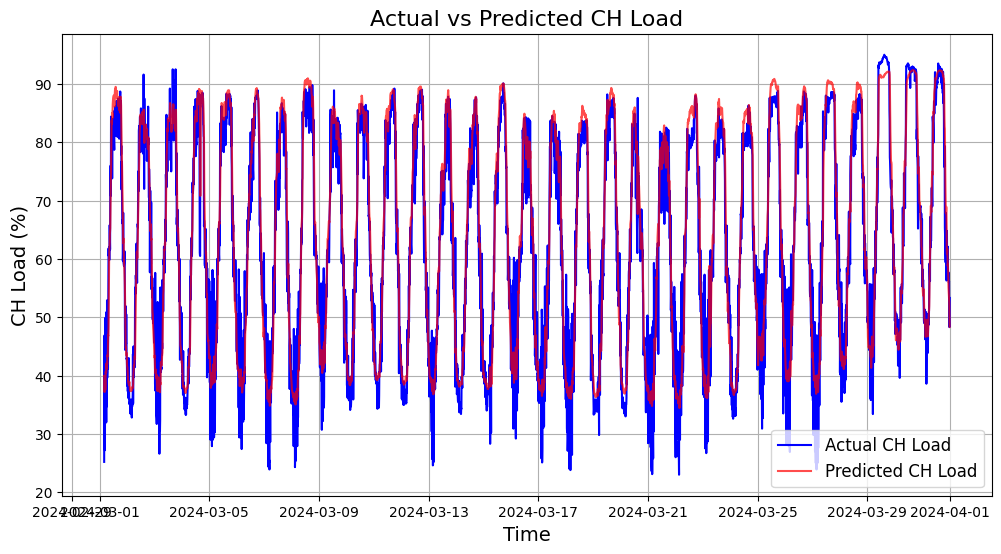

In [39]:
# Plot Actual vs Predicted CH Load
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Time'], comparison_df['Actual CH Load'], label='Actual CH Load', color='blue')
plt.plot(comparison_df['Time'], comparison_df['Predicted CH Load'], label='Predicted CH Load', color='red', alpha=0.7)
plt.title('Actual vs Predicted CH Load', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('CH Load (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [32]:
# If 'CH Load' is available in new data
if 'CH Load' in new_df.columns:
    y_new_actual = new_df['CH Load'].values[seq_length:]
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_new_actual, y_new_pred)
    rmse = np.sqrt(mean_squared_error(y_new_actual, y_new_pred))
    r2 = r2_score(y_new_actual, y_new_pred)
    print(f"New Data MAE: {mae:.2f}")
    print(f"New Data RMSE: {rmse:.2f}")
    print(f"New Data R^2 Score: {r2:.2f}")


New Data MAE: 4.06
New Data RMSE: 5.31
New Data R^2 Score: 0.92
